# Prediction of vehicle sale timeline

In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_selection import *
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split , learning_curve,ShuffleSplit
from sklearn.ensemble import GradientBoostingRegressor, BaggingRegressor, AdaBoostRegressor,RandomForestRegressor, ExtraTreesRegressor
import warnings
from sklearn.model_selection import RandomizedSearchCV
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
import plotly
from plotly import tools
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go

np.random.seed(31415)# for reproducibility

In [2]:
#importing the dataset
warnings.filterwarnings('ignore')
data0=pd.read_csv('/Users/miladsheikhlari/Downloads/VehicleSale-master/xyz.csv')

In [3]:
#viewing the data and some explorartory analysis
data0.head(5)


,bounceRate,uniquePageviews,avgTimeOnPage,sale_class,year,asking_price,Month(date_added),weekday(date_added),dayOfMonth(date_added),daysOnWeb
0,58.333333,243,163.186916,Used,2014,23995,8,1,28,161
1,70.000000,223,174.712575,Used,2013,9995,8,1,28,134
2,76.000000,192,216.705882,Used,2018,24995,9,5,1,153
3,76.923077,166,119.732824,New,2017,27143,10,1,30,2
4,69.444444,178,133.033898,Used,2015,21995,9,5,8,90


In [4]:
#Need to transform sale_class,year,month,weekday,dayofMonth to categorical variables 

def to_categorical(df):
    for index in df.columns:
        if index in ['sale_class','year','Month(date_added)','weekday(date_added)','dayOfMonth(date_added)']:
            df[index]=df[index].astype('category')
    return df

data1=to_categorical(data0)

In [5]:
data1.shape

(813, 10)

In [6]:
data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 813 entries, 0 to 812
Data columns (total 10 columns):
bounceRate                813 non-null float64
uniquePageviews           813 non-null int64
avgTimeOnPage             813 non-null float64
sale_class                813 non-null category
year                      813 non-null category
asking_price              813 non-null int64
Month(date_added)         813 non-null category
weekday(date_added)       813 non-null category
dayOfMonth(date_added)    813 non-null category
daysOnWeb                 813 non-null int64
dtypes: category(5), float64(2), int64(3)
memory usage: 39.0 KB


In [7]:
#our data set doesn't have any  null values which makes preprocessing easier
data1.describe()

,bounceRate,uniquePageviews,avgTimeOnPage,asking_price,daysOnWeb
count,813.000000,813.000000,813.000000,813.000000,813.000000
mean,26.595088,16.623616,121.227205,32018.191882,76.575646
std,38.904505,27.323568,145.091576,14408.133609,74.877063
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,33.333333,22995.000000,14.000000
50%,0.000000,5.000000,82.222222,31443.000000,49.000000
75%,61.538462,19.000000,162.500000,41978.000000,128.000000
max,100.000000,243.000000,1606.000000,134750.000000,303.000000


In [8]:
#Distribution of the outcome variable daysOnWebsite for both used and new sale classes 
#initiate the Plotly Notebook mode
init_notebook_mode(connected=True)

traceAll={"x":data1['daysOnWeb'],"type":"box","name":"Both Classes"}



traceNew = {
    "x":data1['daysOnWeb'].groupby(data1['sale_class']).get_group('New'),
    "type":"box",
    "name":"New Class",
}
traceUsed = {
    "x":data1['daysOnWeb'].groupby(data1['sale_class']).get_group('Used'),
    "type":"box",
    "name":"Used Class",
}

fig = tools.make_subplots(rows=3, cols=1)
fig.append_trace(traceAll,1,1)
fig.append_trace(traceNew, 2, 1)
fig.append_trace(traceUsed, 3, 1)
fig['layout']['title']="<b>Number of Days by 'sale_class' Box Plot</b>"
#fig.layout = {"title": "<b>Number of Days by 'sale_class' Box Plot</b>"}

iplot(fig)

This is the format of your plot grid:
[ (1,1) x1,y1 ]
[ (2,1) x2,y2 ]
[ (3,1) x3,y3 ]



We notice that the outcome variables is positively skewed for both classes. The median number of days until sale are 70.5 and 26 days for the new and old class respectively. Also, In the the combined classes boxplot we notice a small number of  outliers values greater than 298.

In [9]:
layout = go.Layout(title='Price vs. Days to sale')
fig = go.Figure([go.Scatter(x=data1['asking_price'],y=data1['daysOnWeb'],mode = 'markers')], layout=layout)
iplot(fig)

As the scatter plot shows there are potential outliers in the data that need to be dealt with before we can proceed to modelling the data. In the following step the density based clustering algorithm DBSCAN is used to detect outliers

In [10]:

#Standardizing the data is key for most of the clustering techniques to avoid a feature biasing the results of clustering

X = StandardScaler().fit_transform(data1._get_numeric_data())
A = []
B = []
C = []

for i in np.linspace(0.1,5,50):
    # we would like to eventually use this to see how the number of outliers varies as the distance variable eps increases-
    #from 0.1 to 5
    db = DBSCAN(eps=i, min_samples=10).fit(X)

    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    labels = db.labels_
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    
    add = 0
    for t in labels:
        if t == -1: 
            add = add + 1
    C.append(add)
            
    
    
    A.append(i)
    B.append(int(n_clusters_))

    


labels are the label of the clusters. If the label is -1, then the observation is an outlier/noise within our dataset.

db.core_sampleindices are the indices of the core points in the cluster, the indices that are excluded here are of outliers and the edges of the clusters

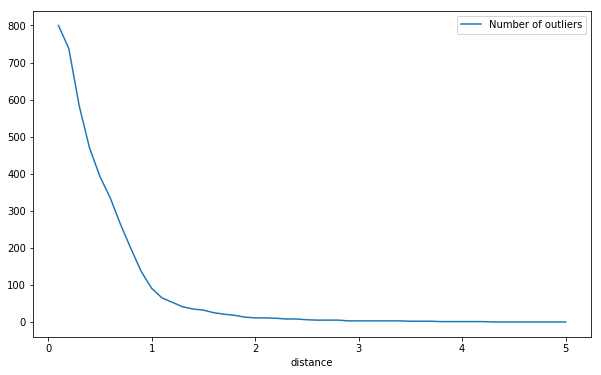

In [11]:
results = pd.DataFrame([A,B,C]).T
results.columns = ['distance','Number of clusters','Number of outliers']
results.plot(x='distance',y='Number of outliers',figsize=(10,6))

Based on the plot I decided to use 1.5 as the distance variable epi since the number of outliers drop to zero after this 

In [12]:
# scale data first
X = StandardScaler().fit_transform(data1._get_numeric_data().values)

db = DBSCAN(eps=1.5, min_samples=10).fit(X)
labels = db.labels_
pd.Series(labels).value_counts()

 0    781
-1     32
dtype: int64

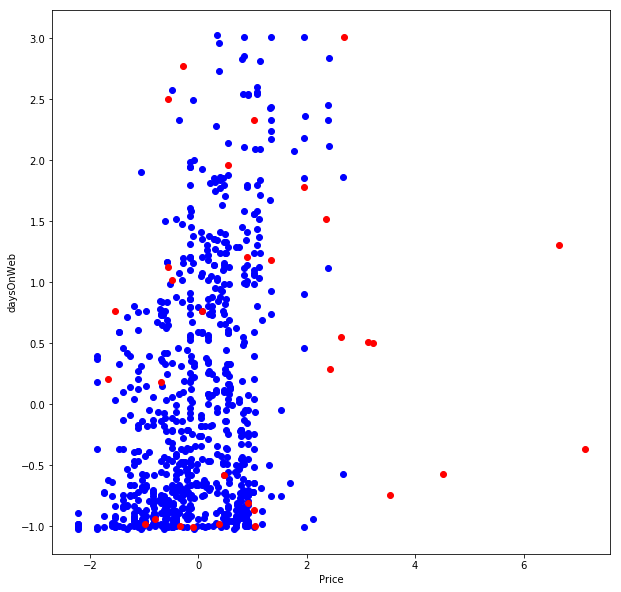

In [13]:
plt.figure(figsize=(10,10))

unique_labels = set(labels)
colors = ['blue', 'red']

for color,label in zip(colors, unique_labels):
    sample_mask = [True if l == label else False for l in labels]
    plt.plot(X[:,3][sample_mask], X[:, 4][sample_mask], 'o', color=color);
plt.xlabel('Price');
plt.ylabel('daysOnWeb');

In [14]:
#separating ouliers from the core data
filtered_data=data1.iloc[db.core_sample_indices_, ]

In [15]:
#processing the data with one hot encoding for our predictive algorithms

filtered_data=pd.get_dummies(filtered_data)
# Use numpy to convert to arrays
# Labels are the values we want to predict
labels = np.array(filtered_data['daysOnWeb'])
# Remove the labels from the features
# axis 1 refers to the columns
filtered_data= filtered_data.drop('daysOnWeb', axis = 1)
# Saving feature names for later use
data_list = list(filtered_data.columns)

#Split the data into training and testing sets
train_data, test_data, train_labels, test_labels = train_test_split(filtered_data, labels, test_size = 0.25, random_state = 42)

transformer=StandardScaler()
train_data=transformer.fit_transform(train_data)
#train_labels=transformer.fit_transform(train_labels.reshape(-1, 1))
#train_labels=maxabs_scale(train_labels, axis=0, copy=True)
test_data=transformer.fit_transform(test_data)
#test_labels=transformer.fit_transform(test_labels.reshape(-1, 1))
#test_labels=maxabs_scale(test_labels, axis=0, copy=True)
# The baseline predictions are the historical averages
baseline_preds =  test_labels.mean()
# Baseline errors, and display average baseline error
baseline_errors = abs(baseline_preds - test_labels)
print('Average baseline error in days: ', round(np.mean(baseline_errors), 2))

Average baseline error in days:  62.15


In [16]:
def model_compare(x_train,y_train,x_test,y_test):
    regressors=[RandomForestRegressor(),
                GradientBoostingRegressor(),AdaBoostRegressor(),ExtraTreesRegressor(),BaggingRegressor()]
    
    regressor_names=["RandForestRegressor","GBoostRegressor","AdaBoostRegressor","ExTreesRegressor","BaggingRegressor"]
    
    metrics_arr=[]#array for storing model metrics
    for index, regressor in enumerate(regressors):
        regressor.fit(x_train,y_train) 
        y_pred=regressor.predict(x_test)
        R2=round(regressor.score(x_test, y_test),3)
        errors= y_test-y_pred
        MAE=round(np.mean(abs(errors)), 3)
        MSE=round(np.sum(errors**2)/len(y_test),3)
        metrics_arr.append([regressor_names[index],R2,MAE,MSE])
    metrics_arr=np.array(metrics_arr)    
    return(pd.DataFrame(metrics_arr,columns=["Model","R-squared","MAE","MSE"]))
       
model_compare(train_data,train_labels,test_data,test_labels)       

,Model,R-squared,MAE,MSE
0,RandForestRegressor,0.767,24.712,1257.654
1,GBoostRegressor,0.784,25.875,1164.476
2,AdaBoostRegressor,0.644,38.244,1917.815
3,ExTreesRegressor,0.721,26.609,1506.203
4,BaggingRegressor,0.747,25.929,1362.075


It seems the RandomForest and the GB model are the better performing models amongst the 5 models evaluated. Lets examine the learning curves of the two models to see how they perform with various training set sizes.

In [17]:
fig = tools.make_subplots(rows=1, cols=2,
                          subplot_titles=("Learning Curves (GradientBoosting)",
                                          "Learning Curves (RandomForest))"))

def plot_learning_curve(estimator, X, y, colnum, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 10),
                        ):
    """
    Generate a simple plot of the test and training learning curve.
    https://plot.ly/scikit-learn/plot-learning-curve/

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    if(colnum==1):
        leg=True
    else:
        leg=False
        
    p1 = go.Scatter(x=train_sizes, y=test_scores_mean + test_scores_std,
                    mode='lines',
                    line=dict(color="green", width=1),
                    showlegend=False,  )
    fig.append_trace(p1, 1, colnum)
    
    p2 = go.Scatter(x=train_sizes, y=test_scores_mean - test_scores_std,
                    mode='lines',
                    line=dict(color="green", width=1),
                    showlegend=False, fill='tonexty')
    fig.append_trace(p2, 1, colnum)
    
    p3 = go.Scatter(x=train_sizes, y=train_scores_mean + train_scores_std,
                    mode='lines',
                    line=dict(color="red", width=1),
                    showlegend=False)
    fig.append_trace(p3, 1, colnum)
    
    p4 = go.Scatter(x=train_sizes, y=train_scores_mean - train_scores_std,
                    mode='lines',
                    line=dict(color="red", width=1),
                    showlegend=False, fill='tonexty')
    fig.append_trace(p4, 1, colnum)
    
    p5 = go.Scatter(x=train_sizes, y=train_scores_mean, 
                    marker=dict(color='red'),
                    name="Training score", showlegend=leg)
    fig.append_trace(p5, 1, colnum)
    
    p6 = go.Scatter(x=train_sizes, y=test_scores_mean, 
                    marker=dict(color='green'),
                    name="Cross-validation score", showlegend=leg)
    fig.append_trace(p6, 1, colnum)

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]



In [18]:
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)

plot_learning_curve(GradientBoostingRegressor(), filtered_data,labels,1,cv=cv)
plot_learning_curve(RandomForestRegressor(), filtered_data,labels,2,cv=cv)
fig['layout'].update(hovermode='closest')
iplot(fig)

In [19]:
regressor=GradientBoostingRegressor().fit(train_data,train_labels) 
y_pred=regressor.predict(test_data)
R2=regressor.score(test_data, test_labels)
errors= test_labels-y_pred



The RandomForest model seems to be overfitting on the trainig set and the high difference in the R-squared scores between the training and cross validation sets suggest that the model could benefit from more training data.

The cross validation learning curve seems to be plateauing suggesting more features are needed to improve the model(more model complexity)

In [20]:
layout = go.Layout(title='Residuas vs. Fitted')
fig = go.Figure([go.Scatter(x=y_pred,y=errors,mode = 'markers')], layout=layout)
iplot(fig)

The residual vs.s fiited values plot shows that the magnitude of the errors increases with the inrease in predicted values (demonstrates a cone like shape). This means that the model predicts lower values of the outcome variable more accurately.

In [21]:
layout = go.Layout(title='Actual vs. Fitted')
fig = go.Figure([go.Scatter(x=test_labels,y=y_pred,mode = 'markers')], layout=layout)
iplot(fig)

# Feature Importance

Now the importance of each feature is investigated using a feature importance plot.

In [22]:
regressor_feature_importances = pd.DataFrame(regressor.feature_importances_,
                                   index = data_list,
                                    columns=['Importance']).sort_values('Importance', ascending=False)

In [23]:
print(regressor_feature_importances[regressor_feature_importances.Importance>0.05])

                     Importance
Month(date_added)_4    0.510703
uniquePageviews        0.108387
Month(date_added)_5    0.099108
asking_price           0.097498
year_2018              0.068858


The top most important features that affect the predictability of the modle are:

   1. The month in which the vehicle was added to the inventory (April and May)
   2. The number of times the vehilce was viewed on the dealership's website.
   3. The asking price
   4. The year in which the vehicle was manufactured 

It is worth mentoning that some features are implicityly included in other features for instance the sales class 'new' also corresponds to the year 2018 of the vehicles year of manufacture. 